# TP Final MLII

Para el cierre de la materia Machine Learning II se solicitó la implementación de dos algoritmos vistos durante la materia sobre el mismo dataset con el que se trabajó en Machine Learning I.

Vamos a partir del dataset ya procesado donde tenemos, para la cepa Cabernet Sauvignon, los datos de:
- Puntaje
- Puntaje binario (malo:0, bueno:1, cuyo umbral se había fijado en 88 pts)
- Precio
- Sommelier (one-hot-encoding)
- País (one-hot-encoding)
- Año

Sobre este dataset vamos a implementar los siguientes algoritmos

- Ajuste de hiperparámetros
- Reducción de la dimensionalidad

In [1]:
import pandas as pd

# Levantamos el archivo
final_ds = pd.read_csv('final_ds.csv')

In [2]:
final_ds.head()

,Unnamed: 0,country_Argentina,country_Australia,country_Bulgaria,country_Chile,country_France,country_Israel,country_Italy,country_Portugal,country_Romania,...,taster_Paul Gregutt,taster_Roger Voss,taster_Sean P. Sullivan,taster_Susan Kostrzewa,taster_Unknown,taster_Virginie Boone,year,price,binary_points,points
0,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,2011,19.0,0,87
1,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,2012,34.0,0,87
2,32,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,2010,21.0,0,86
3,53,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,2013,100.0,0,86
4,64,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,2013,40.0,0,86


### Separación y normalización de datos

In [3]:
# Seguiremos utilizando como salida va a ser el puntaje binario
#--------------------------------------------------------------
y = final_ds['binary_points']

In [4]:
# Para los X solo tengo que descartamos las salidas relacionadas con puntaje (la binaria y la otra)
#--------------------------------------------------------------------------------------------------
X = final_ds.drop(['binary_points','points'], axis=1)

In [5]:
import numpy as np

# 7. Hacemos un split en training (70%), validation (20%) y testing (10%) 
#------------------------------------------------------------------------

# Armamos el vector de barajado
n_samples = X.shape[0]
indexes = np.random.permutation(np.arange(0, n_samples))

# Obtenemos los índices del "split" de datos: 80 - 20
train_idx = indexes[0:int(0.8*n_samples)]
test_idx = indexes[int(0.8*n_samples): int(n_samples)]

# Chequeamos que anduvo bien
assert n_samples == train_idx.size + test_idx.size

# Armamos los sets de entrenamiento...
x_train = X.iloc[train_idx,:]
y_train = y.iloc[train_idx].to_numpy()

# ...y test
x_test = X.iloc[test_idx, :]
y_test = y.iloc[test_idx].to_numpy()

### Datos previos: TPF-ML1
En el TPF-ML1 habíamos probado un modelo Random Forest que nos había dado el siguiente resultado:

In [6]:
# Corremos un modelo de random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Vamos primero con la parametrización por defecto (notamos que no tiene sentido agregar mucho más de 10 árboles)
rf_model = RandomForestClassifier(n_estimators=10, max_depth=None, random_state=100)
rf_model.fit(x_train, y_train)

y_predict = rf_model.predict(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict)

print("AUC: ", metrics.auc(fpr, tpr))
print("Confusion Matrix: \n", metrics.confusion_matrix(y_test, y_predict))
print ("Accuracy Test : ", metrics.accuracy_score(y_test,y_predict)*100)

AUC:  0.7325344525866784
Confusion Matrix: 
 [[729 255]
 [246 646]]
Accuracy Test :  73.29424307036247


__NOTA:__ Este no fue el mejor resultado (después se lo tuneó un poco a mano) pero mejor, así probamos el hyperparameter tunign!!!

## 1- Ajuste de hiperparámetros

### GridSearch
Este método explora el espacio de parámetros armando una grilla (cuadrícula) de parámetros donde todas las combinaciones posibles son testeadas. 

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Creamos el diccionario sobre el que vamos a probar variantes
#-------------------------------------------------------------
grid_search = {'criterion':['entropy','gini'],
                 'max_depth': list(np.linspace(5,20,1,dtype=int))+[None],
                 'max_features':['auto','sqrt','log2',None],
                 'min_samples_split':[5,7,10,14],
                 'n_estimators': list(np.linspace(10,850,10,dtype=int))}

# Creamos el modelo
#------------------
clf = RandomForestClassifier()

model = GridSearchCV(estimator = clf, param_grid = grid_search, cv = 4, 
                     verbose = 5, n_jobs = -1)

model.fit(x_train, y_train)

Fitting 4 folds for each of 640 candidates, totalling 2560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   58.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed: 24.3min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed: 34.5min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 50.8min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 56.6min
[Parallel(n_jobs=-1)]: Done 2170 tasks      | elapsed: 68.8min
[Parallel(n_jobs=-1)]: Done 2560 out of 2560 | elapsed: 86.7min finished


GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [5, None],
                         'max_features': ['auto', 'sqrt', 'log2', None],
                         'min_samples_split': [5, 7, 10, 14],
                         'n_estimators': [10, 103, 196, 290, 383, 476, 570, 663,
                                          756, 850]},
             verbose=5)

In [40]:
# Veamos cómo nos quedó el modelo óptimo
#---------------------------------------
print(model.best_estimator_)

RandomForestClassifier(max_depth=5, max_features=None, min_samples_split=5,
                       n_estimators=756)


In [43]:
# Convertimos los resultados en un dataset Pandas para visualizar mejor
#----------------------------------------------------------------------
scores_df = pd.DataFrame(model.cv_results_)
scores_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.110573,0.030504,0.012008,0.001734,entropy,5,auto,5,10,"{'criterion': 'entropy', 'max_depth': 5, 'max_...",0.728145,0.735075,0.771200,0.749333,0.745938,0.016464,247
1,1.270348,0.054638,0.056788,0.002588,entropy,5,auto,5,103,"{'criterion': 'entropy', 'max_depth': 5, 'max_...",0.730810,0.744136,0.758400,0.738667,0.743003,0.010072,394
2,1.584808,0.034150,0.108072,0.010708,entropy,5,auto,5,196,"{'criterion': 'entropy', 'max_depth': 5, 'max_...",0.731876,0.739339,0.758933,0.731200,0.740337,0.011201,586
3,2.692046,0.028360,0.230904,0.014525,entropy,5,auto,5,290,"{'criterion': 'entropy', 'max_depth': 5, 'max_...",0.733475,0.742537,0.764800,0.733867,0.743670,0.012726,336
4,3.425786,0.036967,0.211140,0.021262,entropy,5,auto,5,383,"{'criterion': 'entropy', 'max_depth': 5, 'max_...",0.732409,0.742004,0.762133,0.733333,0.742470,0.011954,448


In [44]:
# Probemos a ver cómo anduvo la cosa
#-----------------------------------
y_predict = model.predict(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict)

print("AUC: ", metrics.auc(fpr, tpr))
print("Confusion Matrix: \n", metrics.confusion_matrix(y_test, y_predict))
print ("Accuracy Test : ", metrics.accuracy_score(y_test,y_predict)*100)

AUC:  0.7480064285292126
Confusion Matrix: 
 [[674 268]
 [205 729]]
Accuracy Test :  74.7867803837953


__Mini-conclusión:__ <br><br> Hubo una mejora!...aunque tampoco descollante. De un Accuracy Test de 0.72 pasamos a casi el 0.75. Pero el tiempo de búsqueda de estos parámetros fue bastante grande (1h 26m), debiendo tener que probar 640 posibles candidatos. La búsqueda de parámetros fue "orientada" según las pruebas que se fueron haciendo manualmente en el TP1 pero con un rango generoso de manera de ver si el valor óptimo no estaba más lejano en el espacio de parámetros.

### RandomSearch
Explora el espacio de parámetros pero de manera más desordenada que Grid Search. A diferencia de GridSearch, no se prueban todos los valores de los parámetros, sino que se muestrea un número fijo de configuraciones de parámetros de las distribuciones especificadas. El número de ajustes de parámetros que se prueban viene dado por n_iter. De esta manera resulta en una búsqueda más eficiente de los parámetros óptimos.

In [45]:
# Random search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

# Creamos el diccionario sobre el que vamos a probar variantes
#-------------------------------------------------------------
random_search = {'criterion':['entropy','gini'],
                 'max_depth': list(np.linspace(5,20,1,dtype=int))+[None],
                 'max_features':['auto','sqrt','log2',None],
                 'min_samples_split':[5,7,10,14],
                 'n_estimators': list(np.linspace(10,850,10,dtype=int))}

# Creamos el modelo
#------------------
clf = RandomForestClassifier()

model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 80,
                          cv = 4, verbose = 5, random_state = 101, n_jobs = -1)

model.fit(x_train, y_train)

Fitting 4 folds for each of 80 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 11.8min finished


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_iter=80,
                   n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [5, None],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_split': [5, 7, 10, 14],
                                        'n_estimators': [10, 103, 196, 290, 383,
                                                         476, 570, 663, 756,
                                                         850]},
                   random_state=101, verbose=5)

In [46]:
# Veamos cómo nos quedó el modelo óptimo
#---------------------------------------
print(model.best_estimator_)

RandomForestClassifier(max_depth=5, max_features=None, min_samples_split=5,
                       n_estimators=383)


In [49]:
# Convertimos los resultados en un dataset Pandas para visualizar mejor
#----------------------------------------------------------------------
scores_df = pd.DataFrame(model.cv_results_)
scores_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_max_features,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,5.964729,0.059959,0.374000,0.007954,663,10,log2,5,entropy,"{'n_estimators': 663, 'min_samples_split': 10,...",0.732942,0.739872,0.760000,0.734933,0.741937,0.010730,62
1,3.416280,0.060699,0.209890,0.010214,383,14,sqrt,5,entropy,"{'n_estimators': 383, 'min_samples_split': 14,...",0.730277,0.743070,0.762667,0.734400,0.742604,0.012470,51
2,3.739495,0.106596,0.305203,0.005921,383,7,sqrt,5,gini,"{'n_estimators': 383, 'min_samples_split': 7, ...",0.731343,0.745736,0.762667,0.733333,0.743270,0.012483,42
3,6.680957,0.068417,0.357238,0.013647,383,14,log2,None,entropy,"{'n_estimators': 383, 'min_samples_split': 14,...",0.750533,0.744670,0.762667,0.761067,0.754734,0.007449,13
4,3.933623,0.021867,0.205387,0.012304,196,7,sqrt,None,entropy,"{'n_estimators': 196, 'min_samples_split': 7, ...",0.742004,0.737207,0.750933,0.752000,0.745536,0.006180,32


In [47]:
# Probemos a ver cómo anduvo la cosa
#-----------------------------------
y_predict = model.predict(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict)

print("AUC: ", metrics.auc(fpr, tpr))
print("Confusion Matrix: \n", metrics.confusion_matrix(y_test, y_predict))
print ("Accuracy Test : ", metrics.accuracy_score(y_test,y_predict)*100)

AUC:  0.7474756429665798
Confusion Matrix: 
 [[673 269]
 [205 729]]
Accuracy Test :  74.73347547974414


__Mini-conclusión:__ <br><br> Los resultados obtenidos con esta búsqueda son similares a los obtenidos para Grid Search (pasamos de 0.72 a casi 0.75 en el Accuracy Test), lo cual era esperable dado que el universo de búsqueda de parámetros era el mismo. Lo notorio en este caso (también esperable) es el muy considerablemente menor tiempo de búsqueda de estos parámetros que fue de casi 12 min al tener que probar solo 80 candidatos (en relación a los 640 candidatos de Grid Search), lo cual se desprende de la naturaleza de búsqueda de este método, aleatoria y basada en probabilidades, más que exhaustiva como en el caso anterior.

### Optimizador Bayesiano

<br>
En la optimización Bayesiana se utiliza la probabilidad para encontrar el mínimo de una función y el objetivo por supuesto es encontrar los parámetros que la minimicen. En nuestro caso la función a minimizar es la media del cross_val_score.

Este método es más eficiente que los dos anteriores (Random Search y Grid Search) en relación a los parámetros encontrados y al tiempo de optimización.

In [54]:
# Instalamos la librería a utilizar
!pip install hyperopt

In [73]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

space = {'criterion': hp.choice('criterion',['entropy','gini']),
         'max_depth': hp.quniform('max_depth',5,20,1),
         'max_features':hp.choice('max_features',['auto','sqrt','log2',None]),
         'min_samples_leaf': hp.uniform('min_samples_leaf', 0, 0.5),
         'min_samples_split': hp.uniform ('min_samples_split', 0, 1),
         'n_estimators': hp.choice('n_estimators',[10,50,350,750,1200])}

def objective(space):
    model = RandomForestClassifier(criterion = space['criterion'],
                                  max_depth = space['max_depth'],
                                  max_features = space['max_features'],
                                  min_samples_leaf = space['min_samples_leaf'],
                                  min_samples_split = space['min_samples_split'],
                                  n_estimators = space['n_estimators'],)
    accuracy = cross_val_score(model,x_train,y_train,cv = 4).mean()
    
    return{'loss':-accuracy,'status':STATUS_OK}

trials = Trials()
best = fmin(fn=objective,
            space = space,
            algo = tpe.suggest,
            max_evals = 80,
            trials = trials)
best

100%|██████████| 80/80 [05:46<00:00,  4.33s/trial, best loss: -0.7382057569296376]


{'criterion': 0,
 'max_depth': 18.0,
 'max_features': 0,
 'min_samples_leaf': 0.2911973047262937,
 'min_samples_split': 0.5193558023164159,
 'n_estimators': 0}

- Devuelve directamente los resultados (parámetros) de la optimización
- Tener en cuenta que para los campos con listas lo devuelto es el índice de la opción óptima (por ejemplo 'n_estimators':0 se refiere a haber seleccionado 10 como el número de estimadores.

In [74]:
# Ahora probamos nuestro modelo con el mejor criterio encontrado
#---------------------------------------------------------------
crit = {0: 'entropy', 1: 'gini'}
feat = {0: 'auto', 1: 'sqrt', 2: 'log2', 3: None}
est = {0: 10, 1: 50, 2: 300, 3: 750, 4: 1200}

trainedforest = RandomForestClassifier (criterion = crit[best['criterion']],
                                       max_depth = best['max_depth'],
                                       max_features = feat[best['max_features']],
                                       min_samples_leaf = best['min_samples_leaf'],
                                       min_samples_split = best['min_samples_split'],
                                       n_estimators = est[best['n_estimators']]).fit(x_train,y_train)

y_predict = trainedforest.predict(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict)

print("AUC: ", metrics.auc(fpr, tpr))
print("Confusion Matrix: \n", metrics.confusion_matrix(y_test, y_predict))
print ("Accuracy Test : ", metrics.accuracy_score(y_test,y_predict)*100)

AUC:  0.7361200143664444
Confusion Matrix: 
 [[698 244]
 [251 683]]
Accuracy Test :  73.61407249466951


__Mini-conclusión:__ <br><br> Los resultados obtenidos con esta búsqueda no son tan buenos como los obtenidos con los métodos anteriores (pasamos de 0.72 a casi 0.74 en el Accuracy Test), pero tener en cuenta que el espacio de búsqueda no fue exactamente igual. Fuera de esto, el resultado es bastante aproximado. Por otro lado el tiempo invertido para la optimización es inclusive bastante menor (aproximadamente la mitad) que en el caso de Random Search, siendo en este caso de solo 5min 46seg.

### Algoritmos genéticos
<br>
Basados en el proceso Darwiniano de selección natural. Se definen poblaciones de modelos y "subsisten" los que presenten mejores características, luego esos modelos heredarán a sus hijos esas características con ciertas modificaciones evolutivas. Implementaremos este modelo mediante la librería TPOT de Python.

In [78]:
# Instalamos la librería TPOT
#----------------------------
!pip install tpot

  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11959 sha256=a8587d74b69176601826bd7d75645189e2552c82380e669c4b8dced4f7ae78c3
  Stored in directory: c:\users\andres\appdata\local\pip\cache\wheels\e2\d2\79\eaf81edb391e27c87f51b8ef901ecc85a5363dc96b8b8d71e3
Successfully built stopit


In [11]:
from tpot import TPOTClassifier

parameters = {'criterion': ['entropy', 'gini'],
               'max_depth': list(np.linspace(5, 20, 1, dtype = int)) + [None],
               'max_features': ['auto', 'sqrt','log2', None],
               'min_samples_leaf': [2, 4, 12],
               'min_samples_split': [5,7,10,14],
               'n_estimators': list(np.linspace(10, 850, 10, dtype = int))}
               
tpot_classifier = TPOTClassifier(generations= 5, population_size= 24, offspring_size= 12,
                                 verbosity= 2, early_stop= 12,
                                 config_dict=
                                 {'sklearn.ensemble.RandomForestClassifier': parameters}, 
                                 cv = 4, scoring = 'accuracy')

tpot_classifier.fit(x_train, y_train)

Optimization Progress:   0%|          | 0/84 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7663266524520256

Generation 2 - Current best internal CV score: 0.7663266524520256

Generation 3 - Current best internal CV score: 0.7663266524520256

Generation 4 - Current best internal CV score: 0.7663266524520256

Generation 5 - Current best internal CV score: 0.7663266524520256

Best pipeline: RandomForestClassifier(input_matrix, criterion=entropy, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=14, n_estimators=663)


TPOTClassifier(config_dict={'sklearn.ensemble.RandomForestClassifier': {'criterion': ['entropy',
                                                                                      'gini'],
                                                                        'max_depth': [5,
                                                                                      None],
                                                                        'max_features': ['auto',
                                                                                         'sqrt',
                                                                                         'log2',
                                                                                         None],
                                                                        'min_samples_leaf': [2,
                                                                                             4,
                                               

In [12]:
# Probemos a ver cómo anduvo la cosa
#-----------------------------------
y_predict = tpot_classifier.predict(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict)

print("AUC: ", metrics.auc(fpr, tpr))
print("Confusion Matrix: \n", metrics.confusion_matrix(y_test, y_predict))
print ("Accuracy Test : ", metrics.accuracy_score(y_test,y_predict)*100)

AUC:  0.7632546757081922
Confusion Matrix: 
 [[699 285]
 [164 728]]
Accuracy Test :  76.06609808102345


__Mini-conclusión:__ <br><br> Los resultados obtenidos con esta búsqueda son los mejores hasta el momento!! (llevaron de 0.72 a 0.76 en el Accuracy Test). El espacio de búsqueda fue prácticamente el mismo que en Grid Search y Random Search. Respecto al tiempo invertido para la optimización es bastante elevado, no tanto como Grid Search pero en el orden de Random Search.

### Artificial Neural Networks (ANNs) Tuning: 
<br>
La idea es aplicar Grid Search o Random Search pero sobre modelos de Deep Learning a través del KerasClassifier. En el TP Final de ML1 habíamos propuesto una red neuronal de clasificación, vamos a utilizar esa misma red e intentar optimizar sus parámetros.

In [22]:
# Definimos el modelo tal cual lo habíamos hecho en el TP Final de ML1
#---------------------------------------------------------------------
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

input_dim = x_train.shape[1]

def DL_Model(activation= 'linear', neurons= 5, optimizer='Adam'):
    model = Sequential()
    model.add(Dense(neurons, input_dim= input_dim, activation= activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])
    return model

# Definimos el espacio de parámetros de búsqueda
#-----------------------------------------------
activation = ['softmax', 'relu', 'tanh', 'sigmoid', 'linear']
neurons = [10, 20, 40, 80, 100]
optimizer = ['SGD', 'Adam', 'Adamax']
param_grid = dict(activation = activation, neurons = neurons, optimizer = optimizer)

clf = KerasClassifier(build_fn= DL_Model, epochs= 20, batch_size=32, verbose= 0)

model = GridSearchCV(estimator= clf, param_grid=param_grid, n_jobs=-1)
model.fit(x_train,y_train)

print("Max Accuracy Registred: {} using {}".format(round(model.best_score_,3), 
                                                   model.best_params_))

Max Accuracy Registred: 0.683 using {'activation': 'linear', 'neurons': 40, 'optimizer': 'Adam'}


In [23]:
# Verificamos cómo anduvo
#------------------------
y_predict = model.predict(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict)

print("AUC: ", metrics.auc(fpr, tpr))
print("Confusion Matrix: \n", metrics.confusion_matrix(y_test, y_predict))
print ("Accuracy Test : ", metrics.accuracy_score(y_test,y_predict)*100)

AUC:  0.5625136716613802
Confusion Matrix: 
 [[957  27]
 [756 136]]
Accuracy Test :  58.26226012793177


__Mini-conclusión:__ <br><br> Los resultados obtenidos con esta búsqueda son algo inferiores a los métodos anteriores (de hecho....bastante malos), pero esto es algo dependiente más del modelo que del método de optimización. Respecto al tiempo invertido para la optimización le llevó unos 25min.

In [20]:
# Solo para ver qué pasa...probemos con una red más compleja, como la propuesta en la diapositiva
#------------------------------------------------------------------------------------------------
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

input_dim = x_train.shape[1]

def DL_Model(activation= 'linear', neurons= 5, optimizer='Adam'):
    model = Sequential()
    model.add(Dense(neurons, input_dim= input_dim, activation= activation))
    model.add(Dense(neurons, activation= activation))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])
    return model

# Definimos el espacio de parámetros de búsqueda
#-----------------------------------------------
activation = ['softmax', 'relu', 'tanh', 'sigmoid', 'linear']
neurons = [10, 20, 40, 80, 100]
optimizer = ['SGD', 'Adam', 'Adamax']
param_grid = dict(activation = activation, neurons = neurons, optimizer = optimizer)

clf = KerasClassifier(build_fn= DL_Model, epochs= 20, batch_size=32, verbose= 0)

model = GridSearchCV(estimator= clf, param_grid=param_grid, n_jobs=-1)
model.fit(x_train,y_train)

print("Max Accuracy Registred: {} using {}".format(round(model.best_score_,3), 
                                                   model.best_params_))

C:\Users\Andres\Anaconda3\envs\AI\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Max Accuracy Registred: 0.685 using {'activation': 'linear', 'neurons': 80, 'optimizer': 'Adamax'}


In [21]:
# Verificamos cómo anduvo
#------------------------
y_predict = model.predict(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict)

print("AUC: ", metrics.auc(fpr, tpr))
print("Confusion Matrix: \n", metrics.confusion_matrix(y_test, y_predict))
print ("Accuracy Test : ", metrics.accuracy_score(y_test,y_predict)*100)

AUC:  0.6974484122643917
Confusion Matrix: 
 [[853 131]
 [421 471]]
Accuracy Test :  70.57569296375267


__Mini-conclusión:__ <br><br> Hay una mejora razonable al complejizar el modelo, aunque el modelo de Random Forest sigue siendo superior. Respecto al tiempo invertido para la optimización le llevó aproximadamente lo mismo, unos 28min.

## 2- Reducción de la dimensionalidad

La idea es explorar técnicas de reducción de dimensionalidad en sus distintas aplicaciones. Puntualmente se tratarán dos casos:

- a. Utilización de reducción de la dimensionalidad como extractor de características
- b. Utilización de reducción de la dimensionalidad como reductor de características no relevantes

### a. Utilización como extractor de características

Se armará un dataset reducido para predecir precios de vinos en función de dos datos, puntaje y año de cosecha.

In [19]:
# Armemos un dataset bien reducido donde vamos a querer discriminar precio en funcion se puntaje/año
#---------------------------------------------------------------------------------------------------
ds_reducido = final_ds[['points','year','price']]

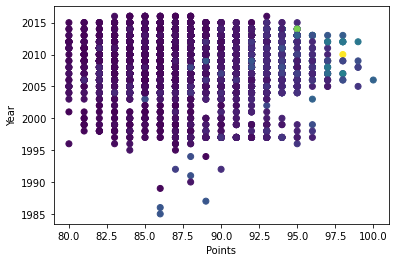

In [20]:
import matplotlib.pyplot as plt

# Veamos que pinta tiene esto
#----------------------------
plt.scatter(ds_reducido['points'], ds_reducido['year'], c = ds_reducido['price'])
plt.ylabel('Year')
plt.xlabel('Points')
plt.show()

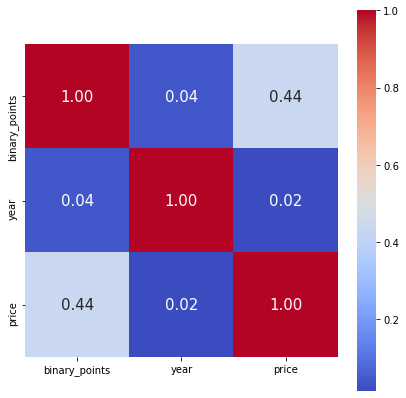

In [70]:
import seaborn as sns

# Veamos en una mapa de correlación cómo están están relacionadas estas variables
#--------------------------------------------------------------------------------
corr = ds_reducido.corr(method='pearson') # .corr is used for find corelation
plt.figure(figsize=(7,7))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= ds_reducido.columns, 
           yticklabels= ds_reducido.columns,
           cmap= 'coolwarm')

plt.show()

__Mini-conclusión:__ <br><br> Vemos que existe una correlación marcada entre puntaje y precio pero no hay practicamente correlación entre año y precio/puntaje. Esto ya no es muy auspicioso (en el sentido en que parece no haber información relevante en el año)...pero bueno, veamos cómo nos va con un modelo de regresión basado en random forest.

#### Regresión con Random Forest

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

# Armamos datos de entrenamiento
#-------------------------------
X = ds_reducido[['points', 'year']].values
y = ds_reducido['price'].values

# Separamos en train y test
#--------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Definimos el modelo a utilizar
#-------------------------------
rfr = RandomForestRegressor(n_estimators = 100, max_depth = 10)

# Entrenamos...
#--------------
rfr.fit(X_train, y_train)

# Vemos que tal dió el ajuste...
#-------------------------------
print('Precisión del modelo (Train Set):', rfr.score(X_train, y_train))
print('Precisión del modelo (Test Set):', rfr.score(X_test, y_test))

Precisión del modelo (Train Set): 0.4327341742160181
Precisión del modelo (Test Set): 0.3698771093748765


__Mini-conclusión:__ <br><br> La precisión del modelo en sí no es muy buena, pero vamos a ver si podemos mejorarla mediante reducción de la dimensionalidad. En rigor en este caso no estamos reduciendo dimensiones sino que sobre las dimensiones existentes (dos) veremos si podemos encontrar las direcciones principales (también dos) lo más ortogonales posibles. De esta manera, si alguna de las dos dimensiones de las que disponíamos tenía algún porcentaje de dependencia de la otra con esta técnica podríamos independizarlas.

In [22]:
from sklearn.decomposition import PCA

# Utilizamos el Principal Components Analysis de Scikit Learn
#------------------------------------------------------------
pca = PCA(n_components=2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

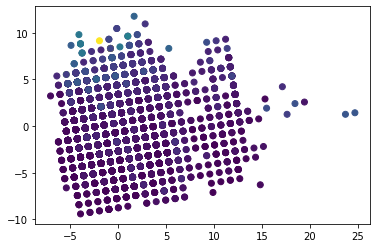

In [24]:
plt.scatter(X_train[:,0], X_train[:,1], c = y_train)

In [25]:
# Entrenamos (utilizando el mismo modelo que antes de aplicar PCA)
#-----------------------------------------------------------------
rfr.fit(X_train, y_train)

# Vemos que tal dió el ajuste
#----------------------------
print('Precisión del modelo (Train Set):', rfr.score(X_train, y_train))
print('Precisión del modelo (Test Set):', rfr.score(X_test, y_test))

Precisión del modelo (Train Set): 0.4334393446585053
Precisión del modelo (Test Set): 0.3703530003144827


__Mini-conclusión:__ <br><br> Verdaderamente el resultado es prácticamente igual y esto se debe a que como ya habíamos anticipado, no parece haber información en la variable aleatoria "año", ni con la salida ni como dependencia con el puntaje. En otro caso esta técnica habría presentado mejoras en el resultado del modelo.

### b. Reducción de features no relevantes

Sobre el dataset final utilizado en el TP Final de ML1 que contaba con 30 features se verificará si la reducción de features a través de PCA y posterior entrenamiento, arroja resultados similares en las predicciones.

Se utilizará también el modelo de regresión basado en Random Forest para la estimación del precio de los vinos.

In [3]:
# Como salida vamos a mantener el precio
#---------------------------------------
y = final_ds['price']

# Para los X descartamos la salida de puntaje binaria (ya que mantenemos la numérica) y la salida (precio)
#---------------------------------------------------------------------------------------------------------
X = final_ds.drop(['binary_points','price'], axis=1)

In [4]:
# Verificamos las cantidad de features que teníamos
#--------------------------------------------------
print('Cantidad de columnas (features):',X.shape[1])

Cantidad de columnas (features): 30


In [6]:
from sklearn.model_selection import train_test_split

# Separamos en datos de entrenamiento y testeo
#---------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

# Definimos el modelo a utilizar (en este caso parametrizamos un poco más en detalle)
#------------------------------------------------------------------------------------
rfr = RandomForestRegressor(criterion = 'mse',
                            n_estimators = 500,
                            max_depth = 15,
                            min_samples_leaf = 3)

# Entrenamos...
#--------------
rfr.fit(X_train, y_train)

# Vemos que tal dió el ajuste...
#-------------------------------
print('Precisión del modelo (Train Set):', rfr.score(X_train, y_train))
print('Precisión del modelo (Test Set):', rfr.score(X_test, y_test))

Precisión del modelo (Train Set): 0.7031637397497947
Precisión del modelo (Test Set): 0.45362253197019076


__NOTA:__ <br><br> A partir de estos valores de precisión del modelo con las 30 características originales veremos si reduciendo características llegamos a precisiones similares.

In [18]:
from sklearn.decomposition import PCA

# Para la evaluación iremos recorriendo un ciclo for que implementa una reducción de las 30
# características originales a de 1 a 10 características finales
#---------------------------------------------------------------
for i in range(1,11):
    
    X_train_pca = X_train.copy()
    X_test_pca = X_test.copy()
    
    # Reducimos dimensiones con PCA
    #------------------------------
    
    # Ajustamos con el train set
    pca = PCA(n_components=i)
    pca.fit(X_train_pca)
    
    # Transformamos train y tests sets
    X_train_pca = pca.transform(X_train_pca)
    X_test_pca = pca.transform(X_test_pca)

    # Entrenamos...
    #--------------
    rfr.fit(X_train_pca, y_train)

    # Vemos que tal dió el ajuste...
    #-------------------------------
    print('Precisión del modelo con %s dimensiones (Train Set):'%i, rfr.score(X_train_pca, y_train))
    print('Precisión del modelo con %s dimensiones (Test Set):'%i, rfr.score(X_test_pca, y_test))
    print('\n')

Precisión del modelo con 1 dimensiones (Train Set): 0.26281992631034234
Precisión del modelo con 1 dimensiones (Test Set): 0.08571532942211091


Precisión del modelo con 2 dimensiones (Train Set): 0.42550529884137667
Precisión del modelo con 2 dimensiones (Test Set): 0.12188202896980171


Precisión del modelo con 3 dimensiones (Train Set): 0.6762636449977724
Precisión del modelo con 3 dimensiones (Test Set): 0.39915154709033507


Precisión del modelo con 4 dimensiones (Train Set): 0.7258987467212497
Precisión del modelo con 4 dimensiones (Test Set): 0.4736668455320273


Precisión del modelo con 5 dimensiones (Train Set): 0.7291000856388177
Precisión del modelo con 5 dimensiones (Test Set): 0.4745310448810256


Precisión del modelo con 6 dimensiones (Train Set): 0.7314939867300041
Precisión del modelo con 6 dimensiones (Test Set): 0.4765630033543403


Precisión del modelo con 7 dimensiones (Train Set): 0.7347014650521386
Precisión del modelo con 7 dimensiones (Test Set): 0.4807674854981

__Mini-conclusión:__ <br><br> Como se puede ver en los resultados sería posible reducir las características totales que describen el problema de 30 a 4 obteniendo aún preciones similares del modelo. Por supuesto esto implicaría ventajas en la complejidad y el tiempo de procesamiento tanto en la etapa de entrenamiento como de testeo.

Con menos de 4 características sí comienza a verse una degradación de la precisión. Con más de 4 características las mejoras en precisión no son sustanciales.